In [1]:
import glob
import os
import cv2
import glob
import importlib

import _pickle as pkl
import numpy as np
import pandas as pd

In [2]:
import analyze2p.utils as hutils
import analyze2p.plotting as pplot

import analyze2p.receptive_fields.utils as rfutils
import analyze2p.aggregate_datasets as aggr
import pylab as pl

In [3]:
visual_areas=['V1', 'Lm', 'Li']
sdata, cells0 = aggr.get_aggregate_info(visual_areas=visual_areas, return_cells=True)
meta = sdata[sdata.experiment.isin(['rfs', 'rfs10'])].copy()

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 3 dsets


In [4]:
meta[(meta.visual_area=='Li') & (meta.experiment=='rfs')]

,experiment,visual_area,datakey,fov,animalid,session,fovnum
22,rfs,Li,20190522_JC089_fov1,FOV1_zoom2p0x,JC089,20190522,1
31,rfs,Li,20190602_JC091_fov1,FOV1_zoom2p0x,JC091,20190602,1
64,rfs,Li,20191017_JC113_fov1,FOV1_zoom2p0x,JC113,20191017,1


In [5]:
datakey = '20190522_JC089_fov1'
experiment='rfs'

traceid='traces001'
response_type='dff'
do_spherical_correction=False


In [6]:
fit_results, fit_params = rfutils.load_fit_results(datakey, experiment='rfs',
                                    traceid=traceid, response_type=response_type,
                                    do_spherical_correction=do_spherical_correction)
print(fit_results.keys())

dict_keys([8, 34, 35, 38, 42, 71, 75, 85, 99, 107, 115, 116, 119, 122, 124, 128, 137, 138, 139, 143, 145])


In [7]:
row_vals = fit_params['row_vals']
int(np.unique(np.diff(row_vals)))


5

#### Loadng rfmap array (all cells, linearized rfmaps)

In [8]:
importlib.reload(rfutils)

<module 'analyze2p.receptive_fields.utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/receptive_fields/utils.py'>

In [9]:
remake_arrays=False
try:
    rfmaps_arr = rfutils.load_rfmap_array(fit_params['rfdir'],
                                do_spherical_correction=do_spherical_correction)
    assert rfmaps_arr is not None
except AssertionError:
    remake_arrays=True

,0,1,2,3,4,5,6,7,8,9,...,141,142,143,144,145,146,147,148,149,150
0,0.024074,0.010747,0.001546,0.031025,0.001337,0.052855,0.021832,-0.003631,-0.021135,-0.019676,...,0.013859,0.012459,0.004658,0.000825,0.010083,-0.000580,0.044204,0.067195,0.052156,0.033237
1,0.013007,0.007112,-0.017546,0.003044,0.007458,0.085862,-0.014338,0.011849,0.045059,0.025081,...,0.013238,0.007858,0.017777,0.004680,-0.018860,0.005104,0.039892,0.018528,0.012917,0.031681
2,-0.001962,0.022727,0.000967,0.010893,0.002552,0.073208,0.017420,-0.020798,0.003896,0.038404,...,0.000038,0.024719,0.005467,-0.005557,0.006944,-0.001626,0.026429,0.068510,0.004947,0.011341
3,0.013249,0.026864,-0.020983,0.030820,-0.005593,0.054879,0.023531,-0.010477,0.032261,-0.004042,...,0.034202,-0.018855,0.003829,-0.007829,-0.009101,-0.022131,0.019818,0.036503,-0.003777,0.004682
4,0.032593,0.021401,0.007846,0.018694,0.002531,0.069172,0.029076,-0.010087,0.034114,0.001669,...,0.011445,-0.017950,0.006238,-0.011931,-0.018113,-0.003088,0.010935,0.069423,0.021939,0.033000


In [19]:
if remake_arrays:
    trialdata, labels = rfutils.load_trialdata(fit_params)
    rfmaps_arr = rfutils.group_trial_values_by_cond(trialdata)

(231, 151)

## Test fitting 

In [13]:
importlib.reload(rfutils)

<module 'analyze2p.receptive_fields.utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/receptive_fields/utils.py'>

In [10]:
nx = len(fit_params['col_vals'])
ny = len(fit_params['row_vals'])


--- processed traces: dff


In [12]:
roi_list = sorted(list(fit_results.keys()))
print(len(roi_list))
roidf_list = [trialdata[[roi, 'config']] for roi in roi_list]

21


In [13]:
roi = 99
roi_list.index(99)

8

In [14]:
roi_df = roidf_list[8]
roi_df.head()

,99,config
0,0.462021,config216
1,0.165325,config083
2,0.332602,config148
3,-0.067318,config037
4,-0.021743,config095


In [ ]:
col_vals = fit_params['col_vals']
row_vals = fit_params['row_vals']
nx = len(col_vals)
ny = len(row_vals)

In [15]:
roi_df = pd.concat([g for c, g in roi_df.groupby('config')]) 
roi_df.index = roi_df.groupby('config').cumcount().values
responses_df = roi_df.pivot(columns='config', values=roi)

n_resamples = responses_df.shape[0]

bootresp_ = pd.concat([responses_df.sample(n_resamples, replace=True).mean(axis=0)
                       for ni in range(500)], axis=1).reset_index(drop=True)
print(bootresp_.shape)

In [105]:
arr_ = rfutils.sphr_correct_maps(bootresp_[test_cols], fit_params, 
                                          use_lin=False) #, n_processes=1)

Screen res (ds=3x): [360, 640]


In [21]:
%matplotlib inline

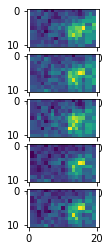

In [107]:
fig, axn = pl.subplots(len(test_cols), 1)
for ax, ri in zip(axn.flat, test_cols):
    ax.imshow(np.reshape(arr_[ri].values, (nx, ny)).T)

In [94]:
importlib.reload(rfutils)

<module 'analyze2p.receptive_fields.utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/receptive_fields/utils.py'>

In [108]:

bootresp = arr_.apply(rfutils.reshape_array_for_nynx, args=(nx, ny))

fitdf_ = bootresp.apply(rfutils.fit_and_return_params, 
                        row_vals=row_vals, col_vals=col_vals)


(231, 5)

In [89]:
# f_ = rfutils.fit_and_return_params(bootresp[399], row_vals=row_vals, col_vals=col_vals) 
# f_

,amplitude,x0,y0,sigma_x,sigma_y,theta,offset,r2
0,0.216882,15.694163,6.141523,2.84312,-2.203703,-0.182677,-0.013662,0.678805


In [115]:
fitdf

,amplitude,x0,y0,sigma_x,sigma_y,theta,offset,r2
0,0.146012,15.472262,5.647095,3.809014,2.350608,-0.196786,-0.015723,0.708681
1,None,None,None,None,None,None,None,None
2,0.146293,14.636263,6.365662,-3.386312,2.56918,-0.108516,-0.015253,0.609394
3,0.202461,14.800791,5.726022,2.036733,2.760355,1.074243,-0.015512,0.665302
4,0.19673,14.57178,5.658369,-2.96635,1.959342,2.499292,-0.012841,0.59


In [114]:
fitdf = fitdf_.T

In [120]:
p = 'sigma_x'
ci=0.95
hutils.get_empirical_ci(fitdf[p].dropna().values, ci=ci)

(-3.3548146570808535, 3.6760930496645368)

In [28]:
response_vector = bootresp_[300].copy()
param_order =['amplitude', 'x0', 'y0', 'sigma_x', 'sigma_y', 'theta', 'offset', 'r2']
rfmap = rfutils.get_rf_map(response_vector.values, nx, ny)            
fitr, fit_y = rfutils.do_2d_fit(rfmap, row_vals=row_vals, col_vals=col_vals)

{'popt': array([ 2.11755446e-01,  1.58359369e+01,  5.96232892e+00,  3.01250083e+00,
         2.18453013e+00, -3.41318500e+00, -1.32499849e-02]),
 'pcov': array([[ 1.69240261e-04, -1.58158612e-04, -1.48140074e-05,
         -1.28698826e-03, -8.10458820e-04, -1.41395682e-05,
         -4.85655092e-06],
        [-1.58158612e-04,  3.48508329e-02, -4.46708741e-03,
          5.56116415e-03, -3.33732535e-04,  1.45343371e-03,
          2.63615272e-05],
        [-1.48140074e-05, -4.46708741e-03,  1.85812068e-02,
         -1.14165161e-03,  6.61971646e-04,  1.09393752e-05,
          1.11134206e-05],
        [-1.28698826e-03,  5.56116415e-03, -1.14165161e-03,
          5.00408766e-02,  5.60079579e-03,  1.52573426e-03,
         -3.20855700e-04],
        [-8.10458820e-04, -3.33732535e-04,  6.61971646e-04,
          5.60079579e-03,  2.23665452e-02,  2.73226976e-05,
         -2.33166795e-04],
        [-1.41395682e-05,  1.45343371e-03,  1.09393752e-05,
          1.52573426e-03,  2.73226976e-05,  1.884932

In [60]:
importlib.reload(rfutils)
%matplotlib inline

0.7293864330206983 True


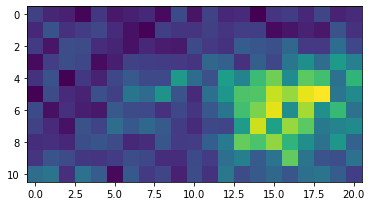

In [61]:
rfmap = rfutils.get_rf_map(rfmaps_arr[99].values, nx, ny)            
fitr, fit_y = rfutils.do_2d_fit(rfmap, row_vals=row_vals, col_vals=col_vals, 
                                verbose=True)
print(fitr['r2'], fitr['success'])
pl.figure()
pl.imshow(rfmap)


In [59]:
3*5*2.53

37.949999999999996

In [25]:
importlib.reload(rfutils)

<module 'analyze2p.receptive_fields.utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/receptive_fields/utils.py'>

## Test on single cell -- Spherical Correction

In [26]:
rid = 99 # 20190522_JC089_fov1, rfs (not rfs10)
rfmaps_arr[99].values.shape

(231,)

In [36]:
resolution_ds=[360, 640]

lin_x, lin_y = rfutils.get_lin_coords(resolution=resolution_ds, cm_to_deg=True)
cart_x, cart_y, sphr_th, sphr_ph = rfutils.get_spherical_coords(
     cart_pointsX=lin_x, cart_pointsY=lin_y, cm_to_degrees=False)

#
cart_x_none, cart_y_none, sphr_th_none, sphr_ph_none = rfutils.get_spherical_coords(
     cart_pointsX=None, cart_pointsY=None, cm_to_degrees=True, resolution=resolution_ds)

(360, 640) (360, 640)


In [28]:
importlib.reload(rfutils)

<module 'analyze2p.receptive_fields.utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/receptive_fields/utils.py'>

In [37]:
col_vals = fit_params['col_vals']
row_vals = fit_params['row_vals']
rfmap_values = rfmaps_arr[rid].copy()
rf_w= rfutils.warp_spherical_fromarr(rfmap_values, cart_x=cart_x, cart_y=cart_y,   
                       sphr_th=sphr_th, sphr_ph=sphr_ph, resolution=resolution_ds,
                       row_vals=row_vals, col_vals=col_vals,normalize_range=True)
rf_w_none = rfutils.warp_spherical_fromarr(rfmap_values, 
                        cart_x=cart_x_none, cart_y=cart_y_none,   
                       sphr_th=sphr_th_none, sphr_ph=sphr_ph_none, resolution=resolution_ds,
                       row_vals=row_vals, col_vals=col_vals,normalize_range=True)

In [30]:
rfmaps_arr[rid].values==rf_w

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True,  True, False, False,  True, False,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
       False,  True,

In [38]:
rf_w_none==rf_w

array([False, False, False, False, False, False, False, False, False,
       False, False,  True,  True, False,  True,  True, False, False,
        True,  True,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True,  True,  True, False,
        True, False,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True, False,  True, False,  True,  True,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False,  True, False, False, False,  True,
        True,  True,  True, False, False, False,  True,  True,  True,
       False,  True,

In [31]:
%matplotlib notebook

<IPython.core.display.Javascript object>


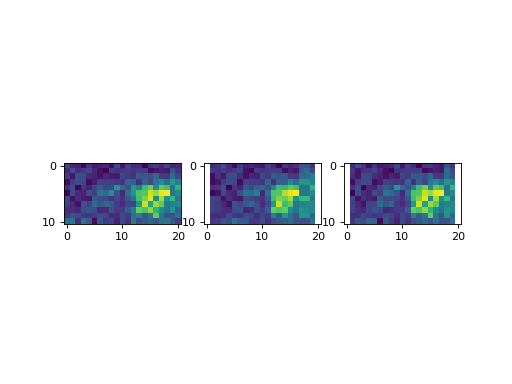

In [39]:
rm = np.reshape(rfmaps_arr[rid].values, (nx, ny)).T
rfmap_sphr = np.reshape(rf_w, (nx, ny)).T
rfmap_sphr_none = np.reshape(rf_w_none, (nx, ny)).T

fig, axn = pl.subplots(1,3)
ax=axn[0]
ax.imshow(rm)

ax=axn[1]
ax.imshow(rfmap_sphr)

ax=axn[2]
ax.imshow(rfmap_sphr_none)

In [40]:
fit_params['sigma_scale'], fit_params['scale_sigma']

(2.35, True)

In [41]:
importlib.reload(rfutils)
%matplotlib notebook

<IPython.core.display.Javascript object>


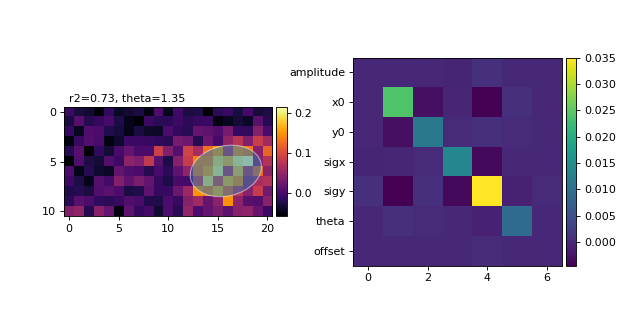

In [42]:
# Fit orig
results_reg, fig = rfutils.plot_and_fit_roi_RF(rfmaps_arr[rid], row_vals, col_vals,
                                           scale_sigma=True, sigma_scale=2.35) 

<IPython.core.display.Javascript object>


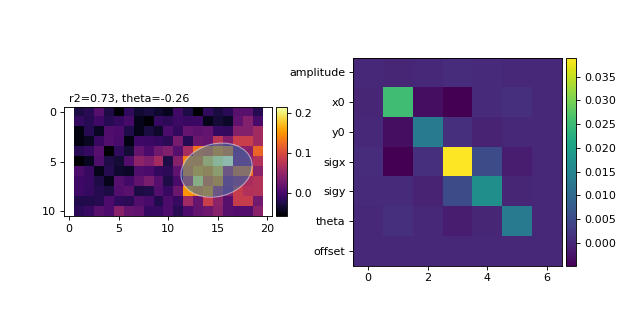

In [35]:
# fit sphere
results_sphr, fig = rfutils.plot_and_fit_roi_RF(pd.Series(rf_w), row_vals, col_vals,
                                           scale_sigma=True, sigma_scale=2.35) 

<IPython.core.display.Javascript object>


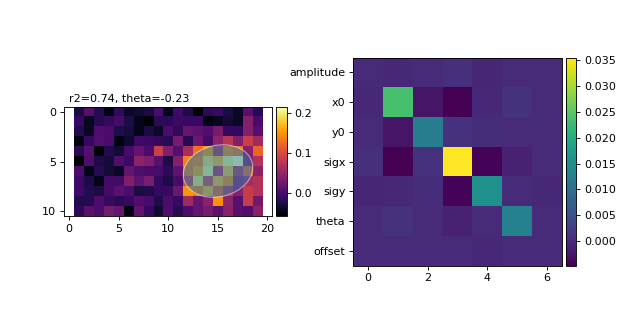

In [47]:
# fit sphere w NONE
results_sphr_none, fig = rfutils.plot_and_fit_roi_RF(pd.Series(rf_w_none), 
                                            row_vals, col_vals,
                                           scale_sigma=True, sigma_scale=2.35) 

In [305]:
importlib.reload(rfutils)
import analyze2p.aggregate_datasets as aggr

In [49]:
#results_sphr.keys()
fitr_sphr = {rid: results_sphr}
fitr_reg = {rid: results_reg}
fitr_sphr_none = {rid: results_sphr_none}


fitdf_reg = rfutils.rfits_to_df(fitr_reg , fit_params, roi_list=[rid], 
                              scale_sigma=True, convert_coords=True)
fit_params2 = fit_params.copy()
fit_params2['use_linear'] = True
fitdf_sphr = rfutils.rfits_to_df(fitr_sphr , fit_params2, roi_list=[rid], 
                              scale_sigma=True, convert_coords=True)

fit_params3 = fit_params.copy()
fit_params3['use_linear'] = False
fitdf_sphr_none = rfutils.rfits_to_df(fitr_sphr_none , fit_params3, roi_list=[rid], 
                              scale_sigma=True, convert_coords=True)

print("Reg. no correction")
print(fitdf_reg.to_markdown())
print("Spherically corrected")
print(fitdf_sphr.to_markdown())
print("Spherically corrected - None spec.")
print(fitdf_sphr_none.to_markdown())


Reg. no correction
|    |      x0 |      y0 |   sigma_x |   sigma_y |   theta |     offset |   amplitude |       r2 |
|---:|--------:|--------:|----------:|----------:|--------:|-----------:|------------:|---------:|
| 99 | 29.0934 | 4.72264 |   25.2978 |   36.4199 | 1.34612 | -0.0131896 |    0.201303 | 0.729386 |
Spherically corrected
|    |      x0 |      y0 |   sigma_x |   sigma_y |   theta |    offset |   amplitude |       r2 |
|---:|--------:|--------:|----------:|----------:|--------:|----------:|------------:|---------:|
| 99 | 24.4225 | 4.30063 |   36.5255 |   26.5345 | 6.02114 | -0.015612 |    0.187113 | 0.726893 |
Spherically corrected - None spec.
|    |      x0 |      y0 |   sigma_x |   sigma_y |   theta |     offset |   amplitude |       r2 |
|---:|--------:|--------:|----------:|----------:|--------:|-----------:|------------:|---------:|
| 99 | 25.1819 | 4.75671 |   35.5147 |   25.9026 | 6.05221 | -0.0158393 |    0.202972 | 0.738103 |


In [307]:
fit_params['use_linear'] = True

In [64]:
fitdf_reg
print_params = ['x0', 'y0', 'theta_Mm_deg', 
                'major_axis', 'minor_axis', 'std_x', 'std_y', 'fx', 'fy']
final_ = rfutils.update_rf_metrics(fitdf_reg, scale_sigma=False)
final_sphr = rfutils.update_rf_metrics(fitdf_sphr, scale_sigma=False)
final_sphr_none = rfutils.update_rf_metrics(fitdf_sphr_none, scale_sigma=False)
print("Reg. no correction")
print(final_[print_params].to_markdown())
print("Spherically corrected")
print(final_sphr[print_params].to_markdown())
print("Spherically corrected - None spec.")
print(final_sphr_none[print_params].to_markdown())


Reg. no correction
|    |      x0 |      y0 |   theta_Mm_deg |   major_axis |   minor_axis |   std_x |   std_y |      fx |      fy |
|---:|--------:|--------:|---------------:|-------------:|-------------:|--------:|--------:|--------:|--------:|
| 99 | 29.0934 | 4.72264 |        167.127 |      36.4199 |      25.2978 | 25.2978 | 36.4199 | 8.11412 | 35.5046 |
Spherically corrected
|    |      x0 |      y0 |   theta_Mm_deg |   major_axis |   minor_axis |   std_x |   std_y |      fx |      fy |
|---:|--------:|--------:|---------------:|-------------:|-------------:|--------:|--------:|--------:|--------:|
| 99 | 24.4225 | 4.30063 |        344.986 |      36.5255 |      26.5345 | 36.5255 | 26.5345 | 35.2786 | 9.46209 |
Spherically corrected - None spec.
|    |      x0 |      y0 |   theta_Mm_deg |   major_axis |   minor_axis |   std_x |   std_y |      fx |      fy |
|---:|--------:|--------:|---------------:|-------------:|-------------:|--------:|--------:|--------:|--------:|
| 99 | 25.18

In [326]:
fitr = {}
fitr['popt'] = copy.copy(fitr_reg[rid]['fit_r']['popt'])
amp_f, x0_f, y0_f, sigx_f, sigy_f, theta_f, offset_f = fitr['popt']
grid_points, cart_vals, sphr_vals = rfutils.coordinates_for_transformation(
    sphr_params)
# converted = fitdf_reg.apply(rfutils.apply_scaling_to_df, 
#                             args=(grid_points, sphr_vals), axis=1) 
# converted
x0_f, y0_f, sigx_f, sigy_f = rfutils.get_scaled_sigmas(grid_points, sphr_vals,
                                               x0_f, y0_f, sigx_f, sigy_f, theta_f,
                                               convert=True)
# fitr['popt'] = (amp_f, x0_f, y0_f, sigx_f, sigy_f, theta_f, offset_f)   
# sphr_params = copy.copy(fit_params)
# sphr_params['do_spherical_correction'] = True
testdf = rfutils.convert_fit_to_coords(fitdf_reg, sphr_params)
testdf

Screen res (ds=3x): [360, 640]
-- converting sphr
Screen res (ds=3x): [360, 640]


,x0,y0,sigma_x,sigma_y,theta,offset,amplitude,r2
99,NaN,NaN,NaN,NaN,1.346117,-0.01319,0.201303,0.729386


In [336]:
testdf2 = pd.DataFrame({'x0': x0_f, 'y0': y0_f, 'sigma_x': sigx_f, 'sigma_y': sigy_f},
                       index=[rid])
testdf2*2.35

,x0,y0,sigma_x,sigma_y
99,81.583469,12.698201,27.560995,34.729675


In [333]:
testdf = rfutils.convert_fit_to_coords(fitdf_reg, sphr_params)
testdf

-- converting sphr
Screen res (ds=3x): [360, 640]


,x0,y0,sigma_x,sigma_y,theta,offset,amplitude,r2
99,NaN,NaN,NaN,NaN,1.346117,-0.01319,0.201303,0.729386


In [334]:
fitdf_sphr

,x0,y0,sigma_x,sigma_y,theta,offset,amplitude,r2
99,24.422507,4.300631,36.52548,26.534497,6.021142,-0.015612,0.187113,0.726893


In [335]:
fitdf_reg

,x0,y0,sigma_x,sigma_y,theta,offset,amplitude,r2
99,29.093374,4.722637,25.297816,36.419946,1.346117,-0.01319,0.201303,0.729386


In [300]:
param_order =['amplitude', 'x0', 'y0', 'sigma_x', 'sigma_y', 'theta', 'offset']
pd.DataFrame(data=[np.array(tuple(fitr['popt']))],
             columns=param_order)


,amplitude,x0,y0,sigma_x,sigma_y,theta,offset
0,0.201303,34.71637,5.40349,11.728083,14.778585,1.346117,-0.01319


In [51]:
screen = hutils.get_screen_dims()
sdf = aggr.get_stimuli(datakey, 'rfs')

In [52]:
importlib.reload(rfutils)
%matplotlib notebook

<IPython.core.display.Javascript object>


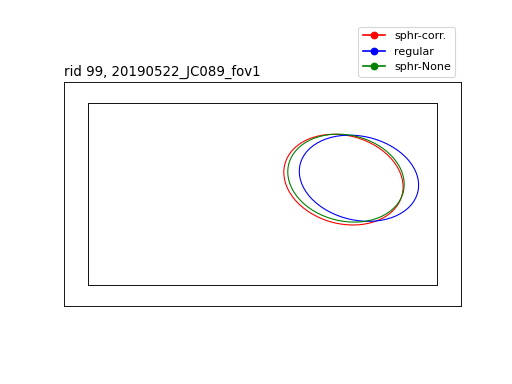

Text(0.0, 1.0, 'rid 99, 20190522_JC089_fov1')

In [57]:
fig, ax = pl.subplots()
ax = rfutils.plot_rfs_to_screen_pretty(fitdf_sphr, sdf, screen, 
                           sigma_scale=1,
                           fit_roi_list=[rid], ax=ax, 
                           ellipse_lw=1, roi_colors=['r'])

ax = rfutils.plot_rfs_to_screen_pretty(fitdf_reg, sdf, screen, 
                           sigma_scale=1,
                           fit_roi_list=[rid], ax=ax, 
                            ellipse_lw=1, roi_colors=['b'])

ax = rfutils.plot_rfs_to_screen_pretty(fitdf_sphr_none, sdf, screen, 
                           sigma_scale=1,
                           fit_roi_list=[rid], ax=ax, 
                            ellipse_lw=1, roi_colors=['g'])

leg_h = pplot.custom_legend_markers(colors=['r', 'b', 'g'], 
                        labels=['sphr-corr.', 'regular', 'sphr-None'], marker='o')
ax.legend(handles=leg_h, bbox_to_anchor=(1,1), loc='lower right')

ax.set_title("rid %i, %s" % (rid, datakey), loc='left')

In [55]:
fit_params['resolution']

KeyError: 'resolution'

In [191]:
rid = 99
roidf = trialdata[[rid, 'config']]


,0,1,2,3,4,5,6,7,8,9,...,143,144,145,146,147,148,149,150,config,trial
0,0.028719,0.064309,-0.030544,0.063003,0.008206,-0.101212,0.048408,0.027061,0.123338,0.038459,...,0.007917,-0.090456,0.014250,0.065603,0.036362,0.037907,0.040256,0.148037,config216,0
1,0.042613,0.035144,-0.123989,-0.005691,0.010927,0.133943,0.184886,0.070137,-0.018134,0.087241,...,-0.036065,-0.028811,0.081758,-0.029896,0.093359,0.012199,-0.009254,0.068885,config083,1
2,0.063744,0.024082,-0.026987,-0.038143,0.005428,-0.030631,0.054766,0.080361,0.057264,0.231844,...,0.129420,0.122346,0.062845,0.065749,-0.058281,0.037414,-0.023979,-0.049566,config148,2
3,-0.045143,-0.020208,0.079090,0.035369,0.001673,0.159735,-0.005144,-0.069483,0.001025,0.099686,...,-0.001469,0.172664,-0.002429,0.045688,-0.047980,0.298143,0.274301,0.054489,config037,3
4,0.009805,0.039317,-0.172005,-0.060506,-0.020698,-0.115748,-0.106595,0.029999,-0.034159,-0.135609,...,0.030159,-0.002349,0.048806,-0.014588,-0.024152,-0.087820,-0.100514,-0.117819,config095,4


## Test evaluation

In [71]:
import pylab as pl
%matplotlib notebook

In [302]:
datakey = '20190612_JC099_fov1'
experiment='rfs10'
do_spherical_correction=False
fit_results, fit_params = rfutils.load_fit_results(datakey, experiment=experiment,
                                traceid=traceid, response_type=response_type,
                                do_spherical_correction=do_spherical_correction)
print(fit_results.keys())

dict_keys([0, 8, 19, 32, 35, 48, 56, 62, 67, 73, 74, 76, 78, 79, 81, 82, 85, 87, 88, 90, 104, 106, 108, 110, 113, 114, 115, 116, 117, 119, 120, 121, 122, 123, 125, 126, 129, 130, 131, 132, 133, 134, 135, 136, 138, 142, 144, 149, 151, 152, 165, 166, 168, 170, 171, 175, 183, 185, 186, 195, 198, 202, 208, 212, 214, 215, 217, 218, 219, 223, 225, 227, 232, 243, 247, 251, 252, 253, 255, 260, 266, 267])


In [333]:
eval_results, _ = rfutils.load_eval_results(datakey, 
                                         rfdir=fit_params['rfdir'])

bootdf = eval_results['bootdf'].copy()

In [318]:
fitdf = rfutils.rfits_to_df(fit_results, fit_params=fit_params,
                    scale_sigma=fit_params['scale_sigma'],
                    sigma_scale=fit_params['sigma_scale'], convert_coords=True)
fitdf = fitdf[fitdf['r2']>fit_params['fit_thr']] 

In [319]:
pass_cis = rfutils.check_reliable_fits(fitdf, eval_results['cis'])
len(pass_cis)

30

In [314]:
importlib.reload(rfutils)

<module 'analyze2p.receptive_fields.utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/receptive_fields/utils.py'>

In [320]:
# eval_results['pass_cis']

In [315]:
# pass_cis = rfutils.check_reliable_fits(fitdf, bootcis)
reliable_rois = rfutils.get_reliable_fits(eval_results['pass_cis'], 
                                          pass_criterion='most')



In [254]:
bootcis = rfutils.get_cis_for_params(eval_results['bootdf'], 
                                     ci=0.95)

In [255]:
rois_ = np.intersect1d(bootcis.index, fitdf.index)
#fitdf.loc[rois_]

In [281]:
importlib.reload(rfutils)
%matplotlib notebook

In [321]:
fitdf = rfutils.rfits_to_df(fit_results, fit_params=fit_params, convert_coords=True)

In [322]:
# fitdf.loc[roi]
# fitdf_c = rfutils.convert_fit_to_coords(fitdf, fit_params, scale_sigma=True,
                                        
# bootdf_c = rfutils.convert_fit_to_coords(bootdf, fit_params, scale_sigma=True,
#                                         convert_coords=True)  

In [334]:
fitdf_roi = fitdf.loc[roi].copy()
bootdf_roi = bootdf[bootdf['cell']==roi].copy()

In [335]:
fitdf_unconv = rfutils.rfits_to_df(fit_results, 
                                   fit_params=fit_params, convert_coords=False)

In [336]:
fitdf_unconv_roi = fitdf_unconv.loc[roi]

In [292]:
fitdf.loc[roi]

x0          -16.656927
y0           -2.393173
sigma_x      34.778326
sigma_y      22.826950
theta         6.253456
offset       -0.006704
amplitude     0.200669
r2            0.927343
Name: 219, dtype: float64

In [295]:
eval_results['cis'].loc[roi][['sigma_x_lower', 'sigma_x_upper']]*sigma_scale

sigma_x_lower    22.384148
sigma_x_upper    38.458054
Name: 219, dtype: float64

In [291]:
pass_cis = rfutils.check_reliable_fits(fitdf, eval_results['cis'])
pass_cis

,x0,y0,sigma_x,sigma_y,theta,offset,amplitude
0,True,True,False,False,False,True,True
8,True,True,False,False,False,True,True
19,True,True,False,False,True,True,True
73,True,True,False,False,False,True,True
74,True,True,False,False,True,True,True
76,True,True,False,False,True,True,True
78,True,True,False,False,True,True,True
79,True,True,False,False,True,True,True
81,True,True,False,False,True,True,True
85,True,True,False,False,True,True,True


In [283]:
%matplotlib inline

In [270]:
bootdfs = bootdf_c.copy()

In [316]:
importlib.reload(rfutils)

<module 'analyze2p.receptive_fields.utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/receptive_fields/utils.py'>

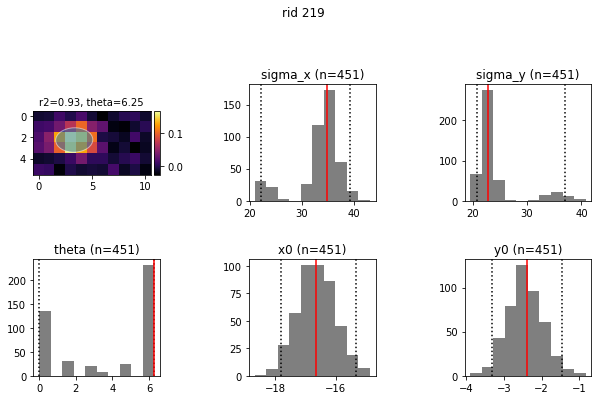

In [337]:
roi = 219
rfmap = fit_results[roi]['data']       
#bootdfs = eval_results['bootdf'].copy()
#bootdf_roi = bootdfs[bootdfs['cell']==roi].copy()    
# bootdf_roi = bootfits.copy()
fig = rfutils.plot_roi_evaluation(roi, fitdf_roi, rfmap, bootdf_roi, fitdf_unconv_roi,
                                 scale_sigma=False)

In [123]:
# trialdata, labels = rfutils.load_trialdata(fit_params)


--- processed traces: dff


In [180]:
roi_list = sorted(list(fit_results.keys()))
roidf_list = [trialdata[[roi, 'config', 'trial']] for roi in roi_list]
print(len(roi_list))


82


In [213]:

fitdf = rfutils.rfits_to_df(fit_results, fit_params=fit_params,
                    scale_sigma=fit_params['scale_sigma'],
                    sigma_scale=fit_params['sigma_scale'])
fitdf = fitdf[fitdf['r2']>fit_params['fit_thr']] 
fitdf.head()

,x0,y0,sigma_x,sigma_y,theta,offset,amplitude,r2
85,1.111327,5.854219,45.961738,34.231365,0.216454,-0.004747,0.087992,0.631459
99,29.093374,4.722637,25.297816,36.419946,1.346117,-0.013190,0.201303,0.729386
115,-0.359113,25.227100,39.363303,31.265256,5.491278,-0.000514,0.089948,0.520312
122,3.931988,24.304596,31.689498,36.726465,6.074524,0.000724,0.086744,0.559490


In [216]:
# trialdata, labels = rfutils.load_trialdata(fit_params) 
# print(trialdata.shape)
# roidf_list = [trialdata[[roi, 'config', 'trial']] for roi in roi_list] 
# print(len(roidf_list))

--- processed traces: dff
(3218, 153)
21


In [133]:
row_vals = fit_params['row_vals']
col_vals = fit_params['col_vals']
nx = len(col_vals)
ny = len(row_vals)
do_spherical_correction = fit_params['do_spherical_correction']
print(do_spherical_correction)

False


In [135]:
param_order =['amp', 'x0', 'y0', 'sigma_x', 'sigma_y', 'theta', 'offset', 'r2']

min_sigma=2.5
max_sigma=50
# xres=1 if do_spherical_correction else float(np.unique(np.diff(row_vals)))
# yres=1 if do_spherical_correction else float(np.unique(np.diff(col_vals)))
# sigma_scale=1 if do_spherical_correction else sigma_scale 

sigma_scale=2.35

nx=len(fit_params['col_vals'])
ny=len(fit_params['row_vals'])
n_reps, n_conds = responses_df.shape
n_bootstrap_iters = 500 #fit_params['evaluation']['n_bootstrap_iters']

fit_params['evaluation'] = {'n_bootstrap_iters': 500, 'ci': 0.95}

In [128]:
roi = 67
ix = roi_list.index(roi)
roi_df= roidf_list[ix]

In [173]:
curr_rois = [ 219, 81, 108, 67]

In [212]:
b_=[]
for roi in curr_rois:
    ix = roi_list.index(roi)
    rdf= roidf_list[ix].copy()
    roi_df = pd.concat([g for c, g in rdf.groupby('config')]) 
    roi_df.index = roi_df.groupby('config').cumcount().values
    responses_df = roi_df.pivot(columns='config', values=roi)
    n_resamples = responses_df.shape[0]
    # #### Resample data
    bootresp_ = pd.concat([responses_df.sample(n_reps, replace=True).mean(axis=0)
                       for ni in range(n_bootstrap_iters)], axis=1)
    # #### Spherically correct maps
    if do_spherical_correction:
        bootresp_ = rfutils.sphr_correct_maps(bootresp_, fit_params)
    bootresp = bootresp_.apply(rfutils.reshape_array_for_nynx, args=(nx, ny))
    # #### Do fitting on each col
    bootfits_ = bootresp.apply(rfutils.fit_and_return_params, 
                               row_vals=row_vals, col_vals=col_vals)
    bootfits = bootfits_.T
    if len(bootfits.shape)==1:
        continue
    bootfits['cell'] = roi
    print(roi, bootfits.shape)
    b_.append(bootfits)

219 (500, 9)
81 (500, 9)
108 (500, 9)
67 (500, 9)


In [266]:
bootdf = pd.concat(b_)
bootdf_c = rfutils.convert_fit_to_coords(bootdf, fit_params)      

In [214]:
bootdf_c.shape, bootdf_c.dropna().shape

((1899, 9), (1899, 9))

In [205]:
bootdf_c['cell'].unique()

array([219,  81, 108,  67])

In [156]:
%matplotlib notebook

In [187]:
bootfits.shape

bootcis = rfutils.get_cis_for_params(bootdf_c, ci=0.95)

In [194]:
counts = bootdf.groupby(['cell']).count()['x0']       
n_bootstrap_iters = fit_params['evaluation']['n_bootstrap_iters']   
unreliable = counts[counts < n_bootstrap_iters*0.5].index.tolist() 
print("%i cells seem to have <50%% iters with fits" % len(unreliable))  

0 cells seem to have <50% iters with fits


In [195]:
eval_results = {'bootdf': bootdf_c,
               'params': fit_params,
               'cis': bootcis,
               'unreliable': unreliable}


In [218]:
bootcis

,amplitude_lower,amplitude_upper,x0_lower,x0_upper,y0_lower,y0_upper,sigma_x_lower,sigma_x_upper,sigma_y_lower,sigma_y_upper,theta_lower,theta_upper,offset_lower,offset_upper,r2_lower,r2_upper
67,0.047868,0.071405,38.680138,52.319166,-10.317522,-1.993104,10.946944,23.386542,9.410684,22.110743,-2.693989,3.603054,-0.011155,-0.006145,0.488909,0.754942
81,0.096133,0.128548,41.092074,52.530691,-9.849602,-6.288840,13.978341,23.308087,12.698599,18.295542,-2.317296,1.663130,-0.011016,-0.002694,0.756641,0.881687
108,0.083824,0.122081,25.226174,32.308055,-5.327905,-1.400601,12.181191,23.668684,11.677456,23.009173,-4.360622,2.039786,-0.011473,-0.001991,0.640432,0.848377
219,0.173663,0.234938,-17.696901,-15.560111,-3.205062,-1.512191,9.640189,16.295984,8.918628,15.831445,-3.269780,6.172473,-0.010066,-0.003684,0.819242,0.918001


In [215]:
fitdf = rfutils.rfits_to_df(fit_results, fit_params=fit_params, 
                    scale_sigma=False, convert_coords=False)
fitdf = fitdf[fitdf['r2']>fit_params['fit_thr']].loc[curr_rois]
fit_rois = fitdf.index.tolist()
fit_rois

[219, 81, 108, 67]

In [200]:
bootcis.keys()

Index(['amplitude_lower', 'amplitude_upper', 'x0_lower', 'x0_upper',
       'y0_lower', 'y0_upper', 'sigma_x_lower', 'sigma_x_upper',
       'sigma_y_lower', 'sigma_y_upper', 'theta_lower', 'theta_upper',
       'offset_lower', 'offset_upper', 'r2_lower', 'r2_upper'],
      dtype='object')

In [203]:
bootcis

,amplitude_lower,amplitude_upper,x0_lower,x0_upper,y0_lower,y0_upper,sigma_x_lower,sigma_x_upper,sigma_y_lower,sigma_y_upper,theta_lower,theta_upper,offset_lower,offset_upper,r2_lower,r2_upper
67,0.047868,0.071405,38.680138,52.319166,-10.317522,-1.993104,10.946944,23.386542,9.410684,22.110743,-2.693989,3.603054,-0.011155,-0.006145,0.488909,0.754942
81,0.096133,0.128548,41.092074,52.530691,-9.849602,-6.288840,13.978341,23.308087,12.698599,18.295542,-2.317296,1.663130,-0.011016,-0.002694,0.756641,0.881687
108,0.083824,0.122081,25.226174,32.308055,-5.327905,-1.400601,12.181191,23.668684,11.677456,23.009173,-4.360622,2.039786,-0.011473,-0.001991,0.640432,0.848377
219,0.173663,0.234938,-17.696901,-15.560111,-3.205062,-1.512191,9.640189,16.295984,8.918628,15.831445,-3.269780,6.172473,-0.010066,-0.003684,0.819242,0.918001


In [219]:
pass_cis = rfutils.check_reliable_fits(fitdf, eval_results['cis'])
len(pass_cis)

4

<IPython.core.display.Javascript object>


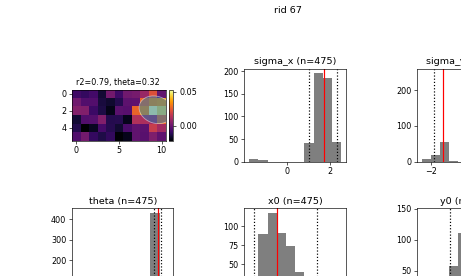

In [158]:
rfmap = fit_results[roi]['data']       
#bootdfs = eval_results['bootdf']
#bootdf_roi = bootdfs[bootdfs['cell']==rid]    
# bootdf_roi = bootfits.copy()
fig = rfutils.plot_roi_evaluation(rid, fitdf.loc[roi], rfmap, bootdf_roi)

In [160]:
bootdf_roi['cell'] = roi

In [161]:

hutils.get_empirical_ci(bootdf_roi[param].dropna().values, ci=ci)

cvals =np.array([hutils.get_empirical_ci(bdf[p].dropna().values, ci=ci)\
          for roi, bdf in bootdf_roi.groupby(['cell'])]) 

In [169]:
cvals[:,1]

array([2.31897694])

In [171]:
rfutils.convert_fit_to_coords(bootdf_roi, fit_params)

,amplitude,x0,y0,sigma_x,sigma_y,theta,offset,r2,cell
0,0.050972,44.209383,-9.38945,17.428089,20.569218,-0.21268,-0.009268,0.639492,67
1,0.061576,40.280474,-7.642192,15.161074,10.135194,0.24794,-0.006972,0.619196,67
3,0.054642,42.889766,-5.621895,14.097569,18.933032,-1.144167,-0.00949,0.698481,67
4,0.055285,47.882742,-5.364957,21.257978,13.750731,-2.66051,-0.007768,0.642188,67
5,0.064672,41.168265,-7.47394,14.442124,11.823316,-6.264119,-0.009454,0.689878,67
...,...,...,...,...,...,...,...,...,...
495,0.063285,41.084883,-5.333545,12.645597,16.466644,-1.17371,-0.009809,0.715034,67
496,0.049057,43.572849,-6.902937,19.770742,11.41456,0.446275,-0.007198,0.561641,67
497,0.064528,44.294146,-7.368841,17.314992,12.09776,-2.691544,-0.009949,0.762417,67
498,0.055603,42.733595,-6.217397,17.458223,16.899799,0.966023,-0.010365,0.684577,67


In [227]:
params = ['amplitude', 'x0', 'y0', 'sigma_x', 'sigma_y', 'theta', 'offset', 'r2']   

In [231]:
import analyze2p.extraction.rois as roiutils

In [253]:
fitdf_roi = fitdf.loc[rid]
fitdf_roi[params]
session, animalid, fovn = hutils.split_datakey_str(datakey)      
traceid='traces001'
fovcoords = roiutils.load_roi_coords(animalid, session, 'FOV%i_zoom2p0x' % fovn,
                                     traceid=traceid, create_new=False)     
posdf = pd.concat([fitdf,
                   fovcoords['roi_positions'].loc[fitdf.index]], axis=1)
posdf = posdf.rename(columns={'x0': 'xpos_rf', 'y0': 'ypos_rf', 
                              'ml_pos': 'xpos_fov', 'ap_pos': 'ypos_fov'})
posdf

,xpos_rf,ypos_rf,sigma_x,sigma_y,theta,offset,amplitude,r2,fov_xpos,fov_xpos_pix,fov_ypos,fov_ypos_pix,xpos_fov,ypos_fov
85,1.111327,5.854219,45.961738,34.231365,0.216454,-0.004747,0.087992,0.631459,463.204697,201,542.559687,285,430.240313,714.395303
99,29.093374,4.722637,25.297816,36.419946,1.346117,-0.013190,0.201303,0.729386,695.959295,302,603.478669,317,369.321331,481.640705
115,-0.359113,25.227100,39.363303,31.265256,5.491278,-0.000514,0.089948,0.520312,467.813699,203,801.465362,421,171.334638,709.786301
122,3.931988,24.304596,31.689498,36.726465,6.074524,0.000724,0.086744,0.559490,504.685714,219,856.673190,450,116.126810,672.914286


In [266]:
importlib.reload(rfutils)
%matplotlib notebook

In [267]:
reliable_rois = eval_results['reliable_rois'] 
len(reliable_rois)

3

<IPython.core.display.Javascript object>


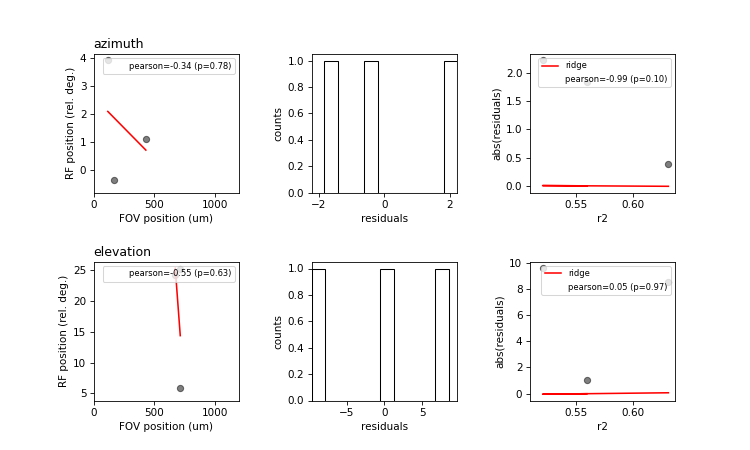

[azimuth] Mean squared error: 1.68 | Variance score: 0.11
[elevation] Mean squared error: 7.45 | Variance score: 0.30


In [268]:
fig = rfutils.plot_linear_regr_by_condition( posdf.loc[reliable_rois],model='ridge')


In [270]:
rfutils.compare_regr_to_boot_params(eval_results, posdf, outdir=evaldir)

NameError: name 'evaldir' is not defined